In [1]:
import pandas as pd
import numpy as np
import matplotlib

In [2]:
# load data
# note: had to manually correct line 3692 -- the fields were shifted over by one place; https://stackoverflow.com/questions/18039057/python-pandas-error-tokenizing-data
data_raw = pd.read_csv('../data/urbandict-word-defs.csv')

/Users/laurie/anaconda3/envs/nlp/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (3,7,8,9,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Inspect for & clean up corrupt data

In [3]:
# inspect columns; we have some extra columns indicating corrupt data
data_raw.columns

Index(['word_id', 'word', 'up_votes', 'down_votes', 'author', 'definition',
       'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10',
       'Unnamed: 11'],
      dtype='object')

In [4]:
# pull out the data with extra columns
extra_data = data_raw[data_raw['Unnamed: 6'].notnull() | data_raw['Unnamed: 7'].notnull() | data_raw['Unnamed: 8'].notnull() | data_raw['Unnamed: 9'].notnull() | data_raw['Unnamed: 10'].notnull() | data_raw['Unnamed: 11'].notnull()]

In [5]:
# how many unique words are defined?
len(data_raw.word.unique())

663058

In [6]:
# how many words have definitions with extra columns?
len(extra_data.word.unique())

117

In [7]:
# less than 1% of the total words are affected by the corruption
117/663058

0.00017645515173634886

In [8]:
# how much of the total *data* is affected? similar proportion
len(extra_data)/len(data_raw)

0.0001945497460839711

In [9]:
data_raw.head()

,word_id,word,up_votes,down_votes,author,definition,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,7,Janky,296,255,dc397b2f,Undesirable; less-than optimum.,NaN,NaN,NaN,NaN,NaN,NaN
1,8,slumpin',16,37,dc397b2f,"low down and funky, but [knee deep] enough to ...",NaN,NaN,NaN,NaN,NaN,NaN
2,9,yayeeyay,19,27,dc397b2f,"affirmation; suggestion of encouragement, appr...",NaN,NaN,NaN,NaN,NaN,NaN
3,12,hard-core,162,96,d1610749,anything out of our league that can be good or...,NaN,NaN,NaN,NaN,NaN,NaN
4,13,brutal,12,45,40ece1ef,anything that makes you sweat,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# seems safe to drop rows that have the extra columns populated - not worth parsing out the corrupted data
data = data_raw[data_raw['Unnamed: 6'].isnull() & data_raw['Unnamed: 7'].isnull() & data_raw['Unnamed: 8'].isnull() & data_raw['Unnamed: 9'].isnull() & data_raw['Unnamed: 10'].isnull() & data_raw['Unnamed: 11'].isnull()].copy()

In [11]:
# drop the now-empty columns 
data.dropna(axis = 1, how = "all", inplace = True)

In [12]:
data.dtypes

word_id        int64
word          object
up_votes      object
down_votes    object
author        object
definition    object
dtype: object

In [13]:
# there are no fractional down votes, but there are some < 0?
# looked directly on Urban Dictionary and they do appear on the site... not clear how/why (seems corrupt)
test = data['down_votes'].astype('str').str.split(".", expand = True)
test[1].unique()

array([None, '0'], dtype=object)

In [14]:
# make the votes numeric
data['up_votes'] = pd.to_numeric(data['up_votes'])
data['down_votes'] = pd.to_numeric(data['down_votes'])

In [15]:
# there are some definitions (~ 100) with negative votes -- not clear why or how to interpret, dropping as invalid
data = data[(data['up_votes'] > 0) & (data['down_votes'] > 0)]

# Explore data

## Category distributions

In [16]:
# make a total votes column and a vote ratio column to explore
data['total_votes'] = data['up_votes'] + data['down_votes']
data['good_ratio'] = data['up_votes'] / data['total_votes']

In [17]:
# how many words do we have? how many definitions?
print(len(data['word'].unique()))
print(len(data))
# we mostly just have one definition per word

604023
981243


In [18]:
data['total_votes'].describe()

count    981243.000000
mean        170.648328
std        1031.351826
min           2.000000
25%          15.000000
50%          39.000000
75%         105.000000
max      368136.000000
Name: total_votes, dtype: float64

In [19]:
data['good_ratio'].describe()

count    981243.000000
mean          0.527565
std           0.225929
min           0.000624
25%           0.340000
50%           0.550000
75%           0.714286
max           0.995783
Name: good_ratio, dtype: float64

In [20]:
# it seems like all the 2-vote definitions are literally identical, so should be dropped
data[data['total_votes'] ==2].describe()

,word_id,up_votes,down_votes,total_votes,good_ratio
count,7.955000e+03,7955.0,7955.0,7955.0,7955.0
mean,1.612870e+06,1.0,1.0,2.0,0.5
std,9.271169e+05,0.0,0.0,0.0,0.0
min,1.196000e+03,1.0,1.0,2.0,0.5
25%,7.327665e+05,1.0,1.0,2.0,0.5
50%,1.789698e+06,1.0,1.0,2.0,0.5
75%,2.493815e+06,1.0,1.0,2.0,0.5
max,2.856686e+06,1.0,1.0,2.0,0.5


In [21]:
data = data[data['total_votes'] > 2]

<AxesSubplot:>

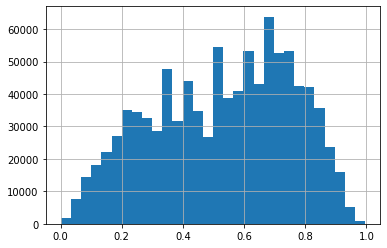

In [22]:
# mode is actaully slightly above .5
data['good_ratio'].hist(bins = 30)

In [23]:
# try equal bins and see what it looks like -- seems reasonable
data['cat'] = pd.qcut(data['good_ratio'], q = 3, labels = ["bad", "controversial", "good"])

## Author

In [24]:
# look at authors - most authors are only going to have one defn.
len(data['author'].unique())

582548

In [25]:
# clearly there is at least one author who writes a LOT more than other people
# see below - looks like it's "anonymous"
data.groupby('author').size().describe()

count    582548.000000
mean          1.670743
std          21.665324
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max       15814.000000
dtype: float64

In [26]:
# confirm - there is an outlier author
data.groupby('author').size().sort_values(ascending = False)

author
a6c97ba3    15814
2438f900     1210
19de25da     1139
21cc121a      991
95a957f4      939
            ...  
a713df77        1
a714028f        1
a7141b9c        1
a7148490        1
1-Dec-56        1
Length: 582548, dtype: int64

In [27]:
# this outlier author seems to have worse definitions than the community average - mean and median are both lower
# checked directly on Urban Dictionary and this appears to be the author ID for "anonymous", so shouldn't drop
data[data['author'] == "a6c97ba3"]["good_ratio"].describe()

count    15814.000000
mean         0.463835
std          0.228927
min          0.012195
25%          0.266028
50%          0.461538
75%          0.662095
max          0.974359
Name: good_ratio, dtype: float64

## Words being defined

In [28]:
data.groupby('word').size().describe()

count    596918.000000
mean          1.630482
std           3.031301
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         351.000000
dtype: float64

In [29]:
# here we are looking at how many definitions there are per word being defined
word_cts = data.groupby('word').size().reset_index().rename(columns = {0:'ct'})

In [30]:
word_cts[word_cts['ct']>1].describe()

,ct
count,124732.000000
mean,4.017237
std,6.064049
min,2.000000
25%,2.000000
50%,2.000000
75%,4.000000
max,351.000000


In [31]:
# look at common words
word_cts[word_cts['ct'] > 100]

,word,ct
362,#NAME?,186
4206,420,126
4593,50 cent,101
42182,Chode,148
67644,Emo,104
85419,George Bush,130
85480,George W. Bush,242
88060,God,216
90491,Green Day,102
100514,Hot Topic,125


In [32]:
# seems to be some data corruption here
data[data['word']=="#NAME?"]

,word_id,word,up_votes,down_votes,author,definition,total_votes,good_ratio,cat
8439,21019,#NAME?,6,10.0,cef9b925,A suffix added to some words to add a ghetto s...,16.0,0.375000,bad
8443,21025,#NAME?,3,4.0,cef9b925,A suffix in replace of words that end with a -...,7.0,0.428571,controversial
9261,22597,#NAME?,12,14.0,25eb7360,used like pig latin and attached to the end of...,26.0,0.461538,controversial
9723,23572,#NAME?,7,11.0,e6ba9da5,one love,18.0,0.388889,bad
12744,30057,#NAME?,14,4.0,9b3bf43d,A suffix indicating a sexual act related to th...,18.0,0.777778,good
...,...,...,...,...,...,...,...,...,...
1013595,2778465,#NAME?,7,9.0,5eb87fc4,"The universal suffix to any word, added purely...",16.0,0.437500,controversial
1018269,2788468,#NAME?,25,4.0,9bd9138f,its a smiling stick man,29.0,0.862069,good
1022292,2797419,#NAME?,14,13.0,eada73cd,Smiley for boring or going to sleep,27.0,0.518519,controversial
1028323,2811710,#NAME?,9,4.0,19581a71,suffix; derived from the word abundance. It's ...,13.0,0.692308,good


In [33]:
data = data[data['word']!="#NAME?"]

## Definition lengths

In [34]:
# characters vs. words
char_lengths = data['definition'].astype(str).apply(len)
word_lengths = data['definition'].astype(str).str.split().apply(len)

In [35]:
char_lengths.describe()

count    973102.000000
mean        165.542778
std         259.043811
min           1.000000
25%          53.000000
50%         100.000000
75%         186.000000
max       32396.000000
Name: definition, dtype: float64

In [36]:
word_lengths.describe()

count    973102.000000
mean         29.328661
std          45.191971
min           1.000000
25%          10.000000
50%          18.000000
75%          33.000000
max        4499.000000
Name: definition, dtype: float64

In [37]:
data['char_len'] = char_lengths
data['word_len'] = word_lengths

In [38]:
# to get percents: https://stackoverflow.com/questions/23627782/pandas-groupby-size-and-percentages
data[data['word_len']<1000].groupby('cat').size().transform(lambda x: round(x/sum(x),2))

cat
bad              0.33
controversial    0.35
good             0.32
dtype: float64

In [39]:
data[data['word_len']>1000].groupby('cat').size().transform(lambda x: round(x/sum(x),2))

cat
bad              0.19
controversial    0.42
good             0.39
dtype: float64

In [40]:
# https://stackoverflow.com/questions/46020761/pandas-numpy-round-down-to-nearest-100
data['word_len_bucket'] = (data['word_len'] / 100).astype(int) * 100

In [41]:
# look at dist. of word lengths
data.groupby('word_len_bucket').size().transform(lambda x: x/sum(x))

word_len_bucket
0       0.960443
100     0.029630
200     0.005903
300     0.002090
400     0.000893
500     0.000433
600     0.000228
700     0.000118
800     0.000075
900     0.000044
1000    0.000040
1100    0.000026
1200    0.000021
1300    0.000012
1400    0.000008
1500    0.000005
1600    0.000005
1700    0.000004
1800    0.000001
1900    0.000002
2000    0.000002
2100    0.000001
2200    0.000003
2300    0.000002
2400    0.000001
2500    0.000001
2700    0.000001
2800    0.000002
2900    0.000001
3000    0.000001
3700    0.000001
3800    0.000001
4400    0.000001
dtype: float64

In [42]:
# drop definitions above 299 words... may need to drop even more 
data = data[data['word_len'] < 300]

In [43]:
# look at the too-short end of the spectrum
for i in range(0,11):
    print("len " + str(i))
    print(len(data[data['word_len'] < i]))

len 0
0
len 1
0
len 2
3853
len 3
14309
len 4
33676
len 5
63841
len 6
99909
len 7
136990
len 8
172985
len 9
208289
len 10
243084


In [44]:
# take only definitions longer than 4 words
data = data[data['word_len']>4]

## Write to file

In [45]:
# how many words do we have? how many definitions? after cleaning
print(len(data['word'].unique()))
print(len(data))

568755
905345


In [47]:
# reassign the bins because we've dropped more rows
data['cat'] = pd.qcut(data['good_ratio'], q = 3, labels = ["bad", "controversial", "good"])

In [48]:
# write this final dataset to file 
data.to_csv("../data/clean_data.csv", index = False)

## Explore
Are longer definitions better? Are more unique words better?

In [53]:
data.head()

,word_id,word,up_votes,down_votes,author,definition,total_votes,good_ratio,cat,char_len,word_len,word_len_bucket
1,8,slumpin',16,37.0,dc397b2f,"low down and funky, but [knee deep] enough to ...",53.0,0.301887,bad,54,11,0
2,9,yayeeyay,19,27.0,dc397b2f,"affirmation; suggestion of encouragement, appr...",46.0,0.413043,bad,64,7,0
3,12,hard-core,162,96.0,d1610749,anything out of our league that can be good or...,258.0,0.627907,controversial,51,11,0
4,13,brutal,12,45.0,40ece1ef,anything that makes you sweat,57.0,0.210526,bad,29,5,0
5,14,skanky,9,48.0,485e4db7,"Anything of or pertaining to a $10,000 hooker.",57.0,0.157895,bad,46,8,0


<AxesSubplot:xlabel='word_len', ylabel='good_ratio'>

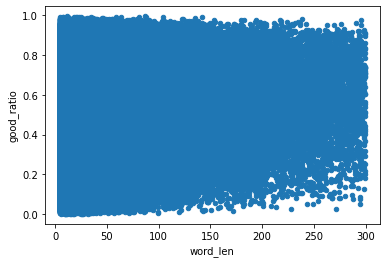

In [51]:
data.plot(x="word_len", y="good_ratio", kind="scatter")

In [54]:
# basically no correlation between defn length and quality
data[['good_ratio', 'word_len']].corr()

,good_ratio,word_len
good_ratio,1.000000,0.084646
word_len,0.084646,1.000000


In [64]:
data[['word_id', 'word', 'up_votes', 'down_votes', 'author', 'definition','good_ratio','cat']].rename(columns = {'cat':'label'}).sample(frac=1.0).head(30).to_csv("../data/example.csv")